<a href="https://colab.research.google.com/github/smmurdock/Regional-Sales-Analysis/blob/main/Regional_Sales_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regional Sales Analysis

Project issued by: Codecademy, Data Analytics Bootcamp (Autumn 2025)

Project completed by: Shanay Murdock

**Purpose:**
This project aims to analyse and visualize regional sales data to uncover trends, evaluate profitability, and support strategic decision-making.

## Setting up the environment and loading data

First, let's start with the initial setup. This involves importing the necessary libraries to perform computations, visualizations, and general analysis, and loading the relevant datasets.

In this section, we will load the provided datasets and perform an initial inspection to understand their structure and content. We'll be using the following libraries for the analysis:
- **pandas:** For data manipulation and analysis.
- **NumPy:** For numerical operations.
- **Matplotlib & Seaborn:** For data visualization.

In [1]:
cd /content/drive/MyDrive/1 Projects/Codecademy DA & AI Bootcamp/EDA Assignment

/content/drive/MyDrive/1 Projects/Codecademy DA & AI Bootcamp/EDA Assignment


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Set the overall style
sns.set_style("whitegrid")
plt.style.use("fivethirtyeight")

# --- Define a Cohesive Color Palette ---
# Use this for consistent category coloring across all charts
region_colors = {
    'South': '#0077b6',     # Blue
    'West': '#00b4d8',      # Light Blue
    'Northeast': '#ffb703', # Orange/Gold
    'Midwest': '#adb5bd'     # Grey
}

channel_colors = {
    'Wholesale': '#0077b6',
    'Distributor': '#00b4d8',
    'Export': '#fb8500',
    'Retail': '#adb5bd'
}

# General sequential palette for rankings (like top products/customers)
sequential_palette = "viridis"

# Diverging palette for correlation heatmap
diverging_palette = "coolwarm"

# Status palette for churn analysis
status_colors = {
    'Active': 'green',
    'Inactive': 'red'
}

Now, let's load the six CSV files into pandas DataFrames. We will then display the first few rows of each DataFrame to get a glimpse of the data.

## 1. Data Cleaning and Preparation

### 1.1 Load and Inspect the Datasets from Excel

In [4]:
# --- Load Data from Excel ---
excel_file_path = 'Regional Sales Dataset.xlsx'
sheet_names = {
    'sales_orders': 'Sales Orders', 'customers': 'Customers',
    'regions': 'Regions', 'state_regions': 'State Regions',
    'products': 'Products'
}
sales_orders_df = pd.read_excel(excel_file_path, sheet_name=sheet_names['sales_orders'])
customers_df = pd.read_excel(excel_file_path, sheet_name=sheet_names['customers'])
regions_df = pd.read_excel(excel_file_path, sheet_name=sheet_names['regions'])
state_regions_df = pd.read_excel(excel_file_path, sheet_name=sheet_names['state_regions'])
products_df = pd.read_excel(excel_file_path, sheet_name=sheet_names['products'])

### 1.2 Standardize and Clean Data

Now, we'll perform the necessary cleaning operations. This includes:
- Making all column names lowercase and replacing spaces with underscores.
- Fixing the header issue in the `state_regions_df`.
- Converting the `OrderDate` column to a proper datetime format.
- Renaming index/key columns for clarity before merging.

In [5]:
# --- Clean and Standardize  ---
def clean_columns(df):
    df.columns = df.columns.str.lower().str.replace(' ', '_')
    return df

sales_orders_df, customers_df, regions_df, products_df = [clean_columns(df) for df in [sales_orders_df, customers_df, regions_df, products_df]]

### 1.3 Merge DataDrames into a Master Datasaet

With the individual tables cleaned, we can now merge them into a single comprehensive DataFrame. We will use the `sales_orders_df` as our base and join the other tables to it using common keys.

In [6]:
state_regions_df.columns = state_regions_df.iloc[0]
state_regions_df = state_regions_df[1:].reset_index(drop=True)
state_regions_df = clean_columns(state_regions_df)

sales_orders_df['orderdate'] = pd.to_datetime(sales_orders_df['orderdate'])

# --- Rename and Merge ---
customers_df.rename(columns={'customer_index': 'customer_name_index'}, inplace=True)
products_df.rename(columns={'index': 'product_description_index'}, inplace=True)
regions_df.rename(columns={'id': 'delivery_region_index'}, inplace=True)

merged_df = pd.merge(sales_orders_df, customers_df, on='customer_name_index', how='left')
merged_df = pd.merge(merged_df, products_df, on='product_description_index', how='left')
merged_df = pd.merge(merged_df, regions_df[['delivery_region_index', 'state_code']], on='delivery_region_index', how='left')
merged_df = pd.merge(merged_df, state_regions_df, on='state_code', how='left')

# Rename `region` column for clarity
merged_df.rename(columns={'region': 'region_name'}, inplace=True)

# --- Feature Engineering: Add Profit Column ---
merged_df['profit'] = merged_df['line_total'] - (merged_df['order_quantity'] * merged_df['total_unit_cost'])

## 2. Categorical Analysis

Now that our data is clean and consolidated, we can analyze our categorical variables to uncover key business trends. In this section, we will visualize performance across different categories to answer questions like:

-   Which sales channels are the most profitable?
-   Which regions drive the most revenue?
-   Who are our most valuable customers?
-   What are our best-selling products?

### 2.1 Analysis of Sales Channel Performance

Let's start by analyzing the performance of our different sales channels. We will group the data by `channel` and calculate the total revenue and profit for each. This will show us which channels are most important to our business.

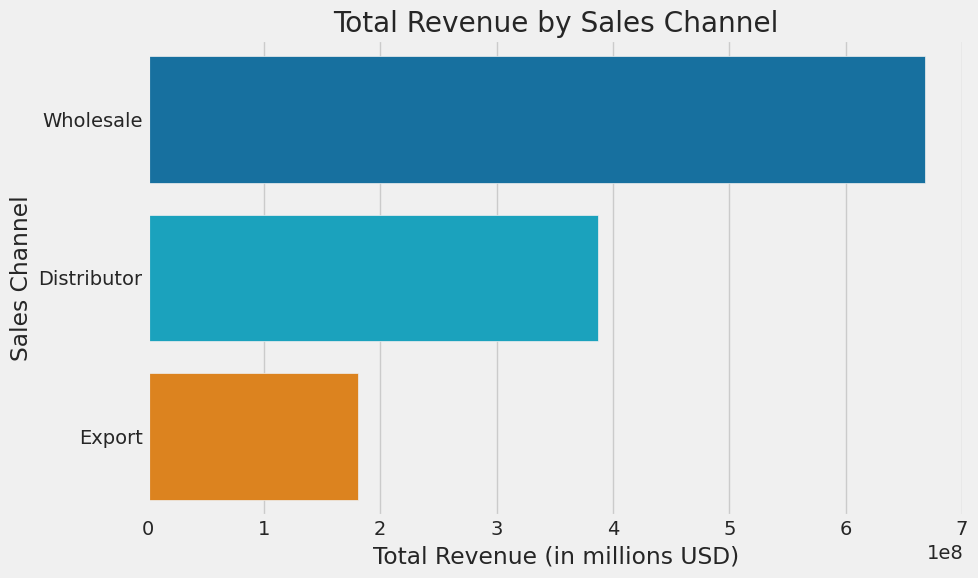

In [7]:
channel_performance = merged_df.groupby('channel').agg(total_revenue=('line_total', 'sum')).sort_values(by='total_revenue', ascending=False).reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(data=channel_performance, x='total_revenue', y='channel', hue='channel', palette=channel_colors, legend=False)
plt.title('Total Revenue by Sales Channel')
plt.xlabel('Total Revenue (in millions USD)')
plt.ylabel('Sales Channel')

plt.tight_layout()
plt.show()

### 2.2 Analysis of Regional Performance

In [8]:
regional_performance = merged_df.groupby('region_name').agg(total_revenue=('line_total', 'sum')).sort_values(by='total_revenue', ascending=False).reset_index()
regional_performance

,region_name,total_revenue
0,West,372142307.6
1,South,335135011.7
2,Midwest,320322363.6
3,Northeast,208369216.1


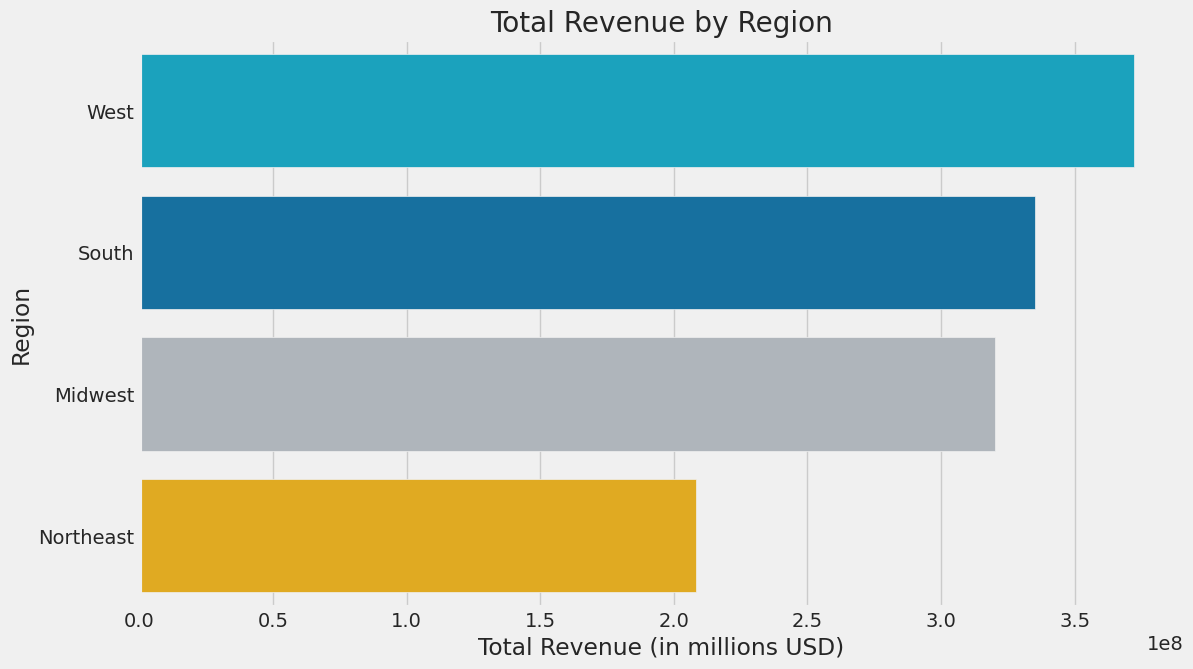

<Figure size 640x480 with 0 Axes>

In [9]:
plt.figure(figsize=(12, 7))
sns.barplot(data=regional_performance, x='total_revenue', y='region_name', hue='region_name', palette=region_colors, legend=False)
plt.title('Total Revenue by Region')
plt.xlabel('Total Revenue (in millions USD)')
plt.ylabel('Region')
plt.show()
plt.tight_layout()
plt.show()

### 2.3 Analysis of Top Customers

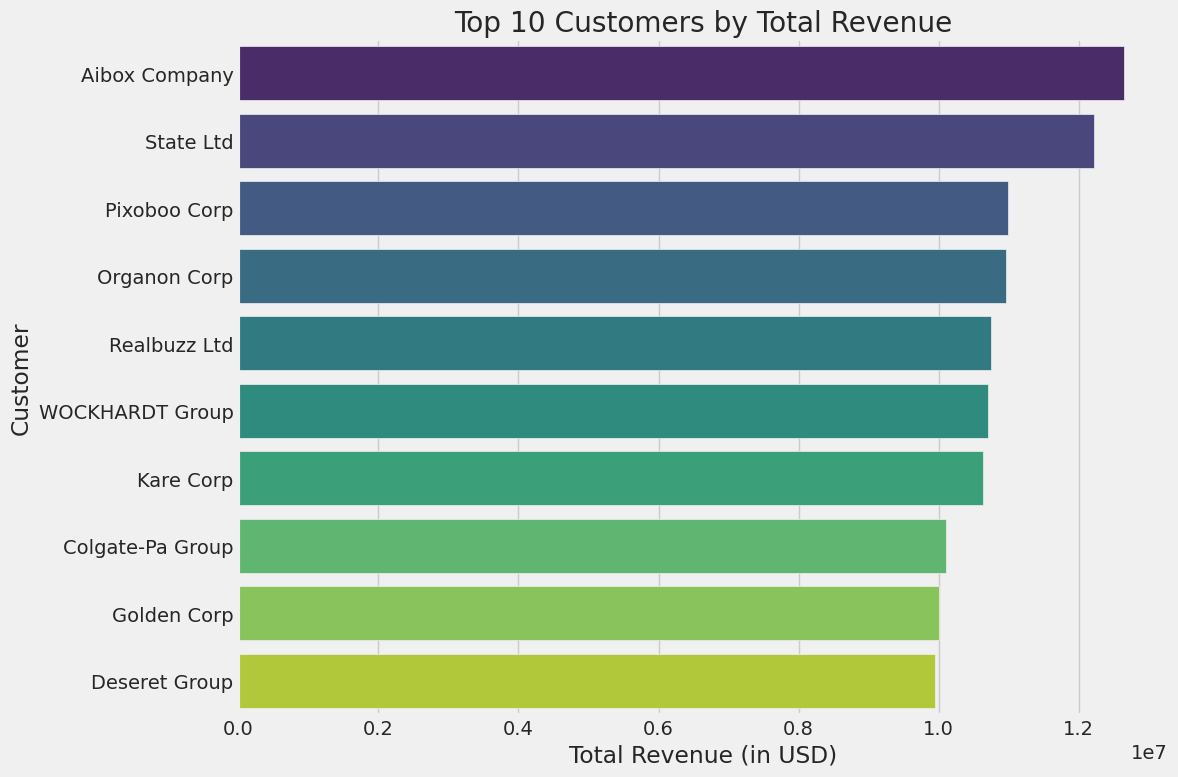

In [10]:
top_customers = merged_df.groupby('customer_names').agg(total_revenue=('line_total', 'sum')).sort_values(by='total_revenue', ascending=False).reset_index().head(10)
plt.figure(figsize=(12, 8))
sns.barplot(data=top_customers, x='total_revenue', y='customer_names', hue='customer_names', palette=sequential_palette, legend=False)
plt.title('Top 10 Customers by Total Revenue')
plt.xlabel('Total Revenue (in USD)')
plt.ylabel('Customer')
plt.tight_layout()
plt.show()

### 2.4 Analysis of Top Products

In [12]:
# Merge the two dataframes to get product names
product_sales_df = pd.merge(sales_orders_df, products_df, on='product_description_index', how='left')

# Group by product name and calculate total revenue and quantity
top_products = product_sales_df.groupby('product_name').agg(
    total_revenue=('line_total', 'sum'),
    total_quantity=('order_quantity', 'sum')
).reset_index()

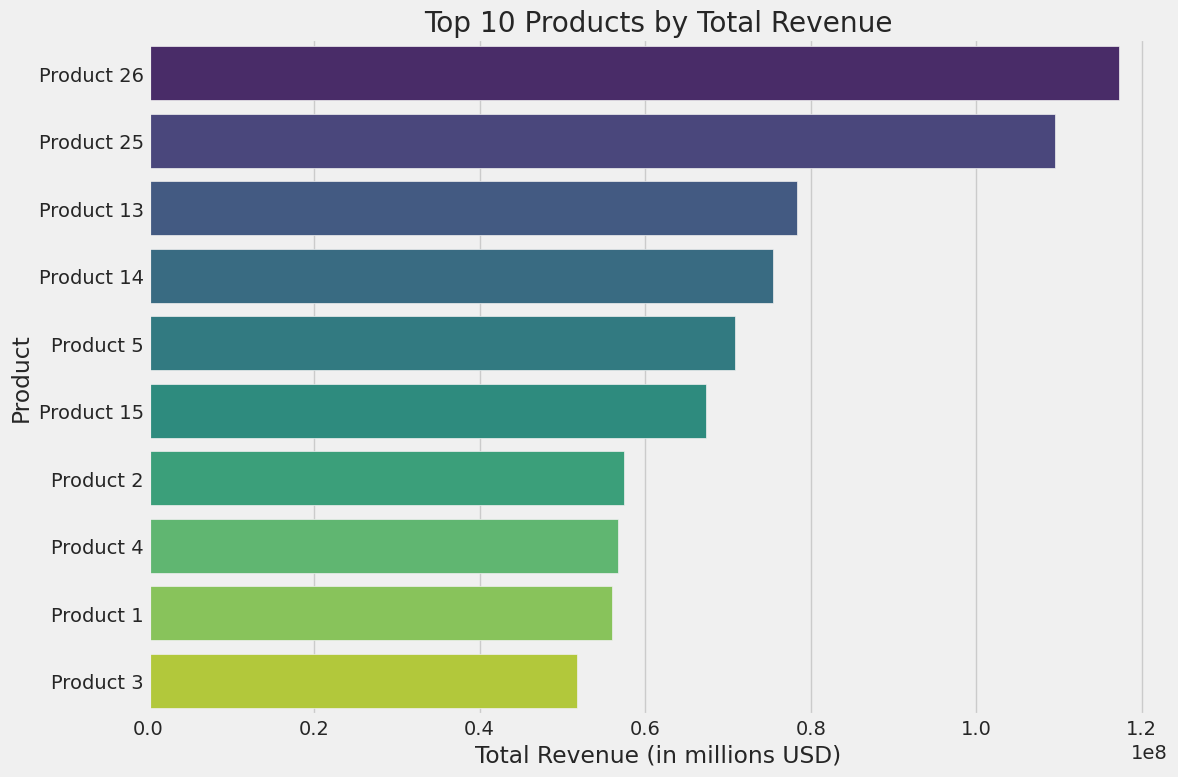

In [13]:
# Sort by Total Revenue and select top 10
top_10_revenue = top_products.sort_values(by='total_revenue', ascending=False).head(10)

# Plot Top 10 by Revenue
plt.figure(figsize=(12, 8))
sns.barplot(
    data=top_10_revenue,
    x='total_revenue',
    y='product_name',
    hue='product_name',
    palette=sequential_palette,
    legend=False
)
plt.title('Top 10 Products by Total Revenue')
plt.xlabel('Total Revenue (in millions USD)')
plt.ylabel('Product')
plt.tight_layout()
plt.show()

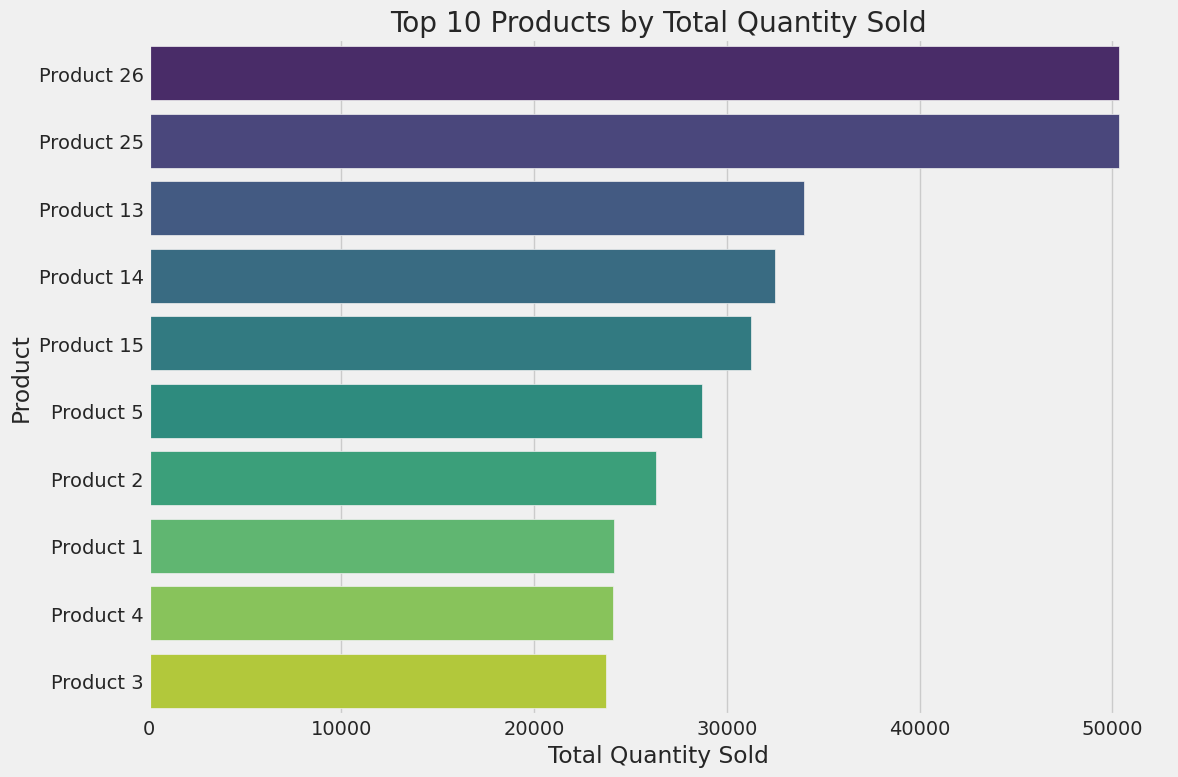

In [14]:
# Sort by Total Quantity Sold and select top 10
top_10_quantity = top_products.sort_values(by='total_quantity', ascending=False).head(10)

# Plot Top 10 by Quantity Sold
plt.figure(figsize=(12, 8))
sns.barplot(
    data=top_10_quantity,
    x='total_quantity',
    y='product_name',
    hue='product_name',
    palette=sequential_palette,
    legend=False
)
plt.title('Top 10 Products by Total Quantity Sold')
plt.xlabel('Total Quantity Sold')
plt.ylabel('Product')
plt.tight_layout()
plt.show()

## 3. Numerical Analysis

In this section, we will explore the numerical variables in our dataset to understand their distributions, central tendencies, and relationships. This analysis is key to identifying patterns in order sizes, pricing, and profitability. We will:

1.  Generate descriptive statistics for a high-level overview.
2.  Visualize the distribution of key metrics like `order_quantity`, `unit_price`, and `profit`.
3.  Analyze the correlation between different numerical variables.

### 3.1 Descriptive Statistics

Let's start by generating a statistical summary of our main numerical columns. The `.describe()` method provides a quick overview of the count, mean, standard deviation, and quartiles for each column. This is a great way to spot anomalies or get a feel for the scale of our data.

In [15]:
# Select numerical columns for analysis
numerical_cols = ['order_quantity', 'unit_price', 'line_total', 'total_unit_cost', 'profit']

# Get descriptive statistics
desc_stats = merged_df[numerical_cols].describe()

print("Descriptive Statistics:")
display(desc_stats)

Descriptive Statistics:


,order_quantity,unit_price,line_total,total_unit_cost,profit
count,64104.000000,64104.000000,64104.000000,64104.000000,64104.000000
mean,8.441689,2284.380803,19280.682937,1432.083899,7203.490577
std,2.276217,1663.598141,15429.602766,1107.705728,6626.122492
min,5.000000,167.500000,837.500000,68.675000,125.625000
25%,6.000000,1031.800000,8019.900000,606.216000,2542.549500
50%,8.000000,1855.900000,14023.100000,1084.495500,5091.464000
75%,10.000000,3606.275000,27416.400000,2046.933750,9922.164000
max,12.000000,6566.000000,78711.600000,5498.556000,45559.464000


### 3.2 Distribution of Numerical Variables

Now, let's visualize the distributions to better understand the patterns. Histograms are perfect for this, as they show the frequency of different values. We'll look at order quantity, unit price, and line total.

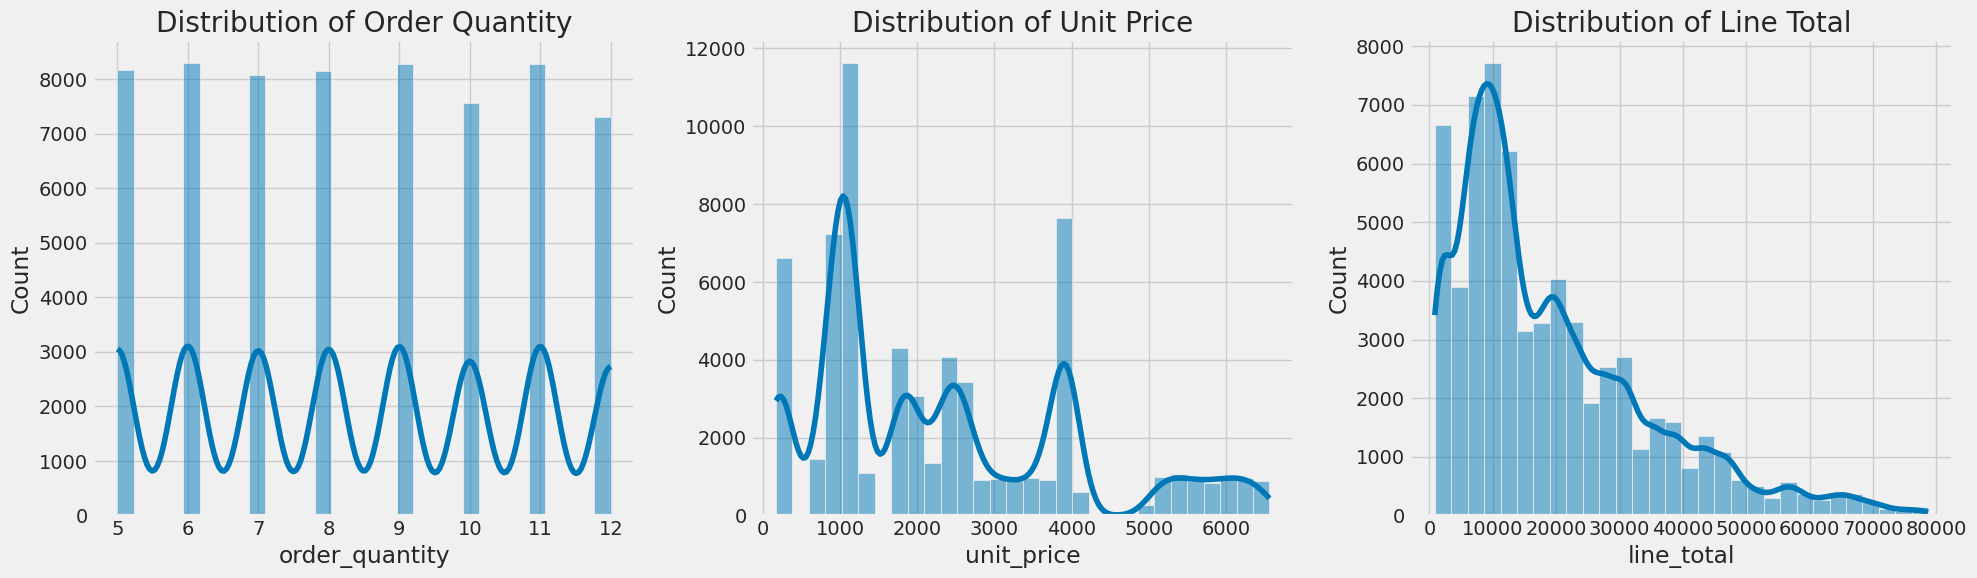

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
primary_color = '#0077b6' # Use our primary blue
sns.histplot(merged_df['order_quantity'], bins=30, kde=True, ax=axes[0], color=primary_color)
axes[0].set_title('Distribution of Order Quantity')
sns.histplot(merged_df['unit_price'], bins=30, kde=True, ax=axes[1], color=primary_color)
axes[1].set_title('Distribution of Unit Price')
sns.histplot(merged_df['line_total'], bins=30, kde=True, ax=axes[2], color=primary_color)
axes[2].set_title('Distribution of Line Total')
plt.tight_layout()
plt.show()

### 3.3 Profitability Distribution by Region

A box plot is an excellent tool for comparing distributions across different categories. Let's use it to see how profit per order is distributed across our main sales regions. This can reveal insights into both profitability and consistency.

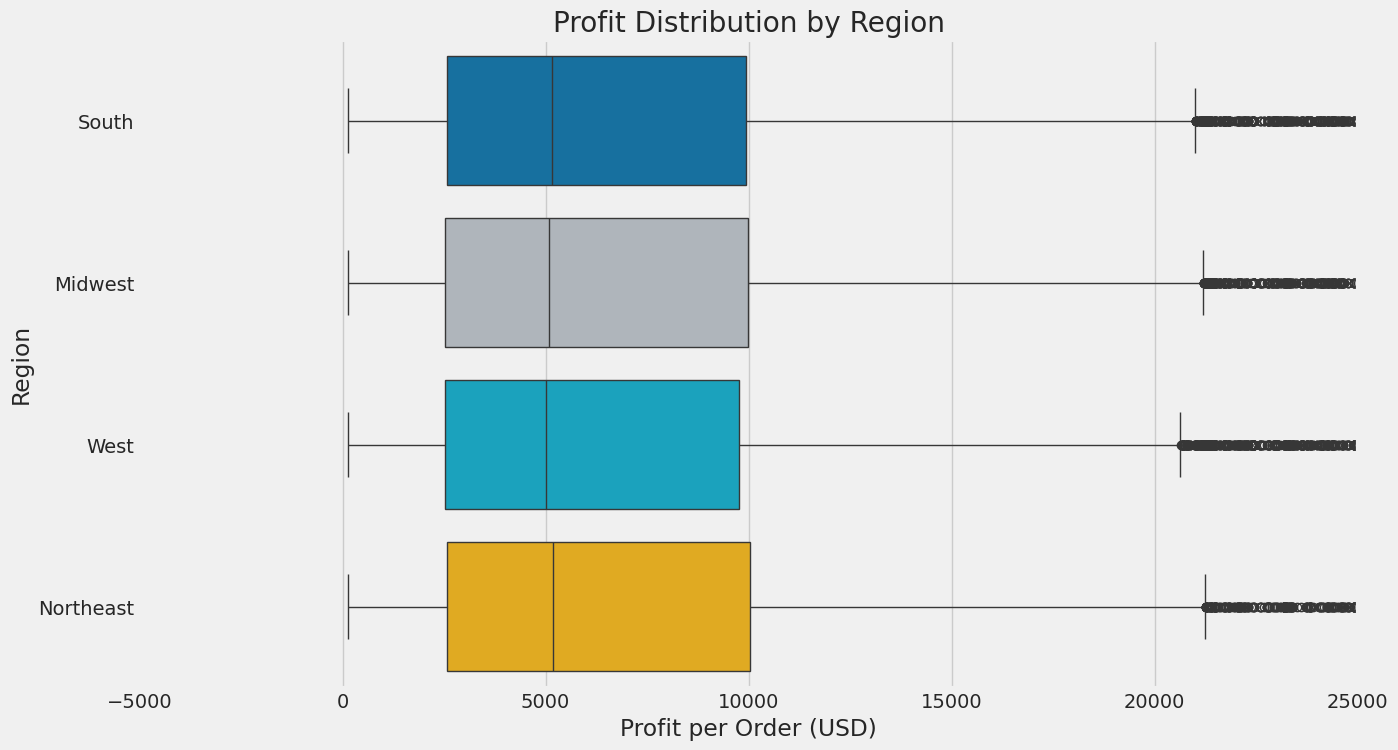

In [17]:
plt.figure(figsize=(14, 8))
sns.boxplot(data=merged_df, x='profit', y='region_name', hue='region_name', palette=region_colors, legend=False)
plt.title('Profit Distribution by Region')
plt.xlabel('Profit per Order (USD)')
plt.ylabel('Region')
plt.xlim(-5000, 25000)
plt.show()

### 3.4 Correlation Analysis

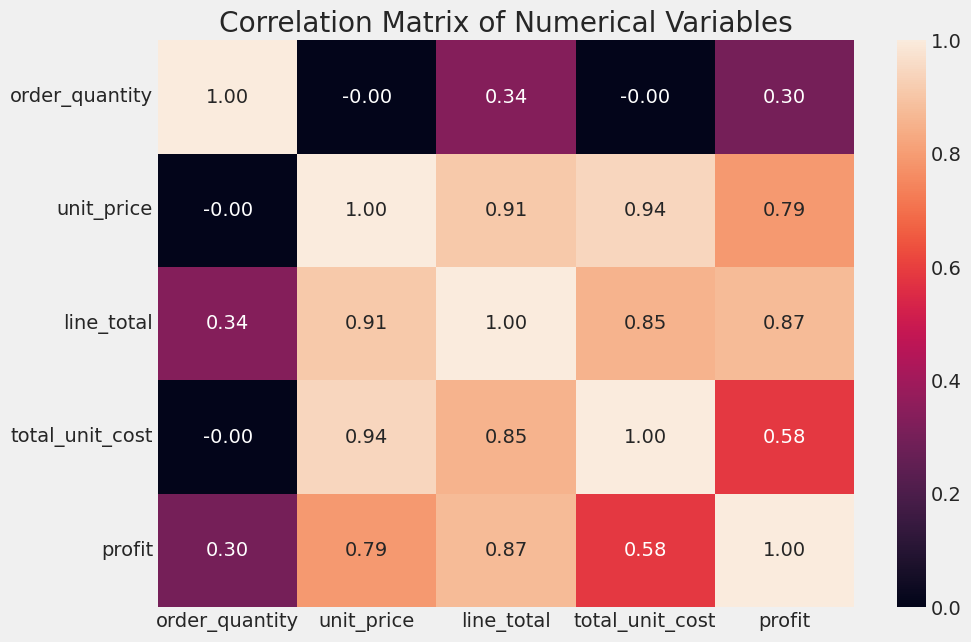

In [18]:
numerical_cols = ['order_quantity', 'unit_price', 'line_total', 'total_unit_cost', 'profit']
correlation_matrix = merged_df[numerical_cols].corr()
plt.figure(figsize=(10, 7))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", vmin=0, vmax=1)
plt.title('Correlation Matrix of Numerical Variables')
plt.show()

## 4. Customer Churn Insights

In this section, we will analyze customer purchasing behavior to identify customers who are at risk of churning or have already become inactive. Our approach will be to:

1.  Calculate the recency of each customer's last purchase relative to the final date in our dataset.
2.  Define a threshold to segment customers into "Active" and "Inactive" (or potentially churned) groups.
3.  Analyze the characteristics of the "Inactive" group to uncover patterns.

### 4.1 Calculate Customer Recency and Define "Active" and "Inactive"

First, we need to find the most recent purchase date for each customer. We'll then calculate the number of days between that last purchase and the end-date of our dataset. This "recency" value tells us how long each customer has been inactive.

Now we'll define a churn threshold. A common business practice is to consider a customer inactive if they haven't purchased in over a year (365 days). We'll use this threshold to create a new 'status' segment.

We are careful here to recognize that we only have January and February data for 2018, and not full year data like the rest of the years.

In [19]:
# --- Calculate Recency and Define Status ---
last_order_date = merged_df['orderdate'].max()
customer_activity = merged_df.groupby('customer_names').agg(last_purchase_date=('orderdate', 'max')).reset_index()
customer_activity['days_since_last_purchase'] = (last_order_date - customer_activity['last_purchase_date']).dt.days
churn_threshold = customer_activity['days_since_last_purchase'].quantile(0.75)
customer_activity['status'] = 'Active'
customer_activity.loc[customer_activity['days_since_last_purchase'] > churn_threshold, 'status'] = 'Inactive'
status_counts = customer_activity['status'].value_counts()
status_counts

,count
status,
Active,140
Inactive,35


### 4.2 Visualize "Active" and "Inactive" Customers

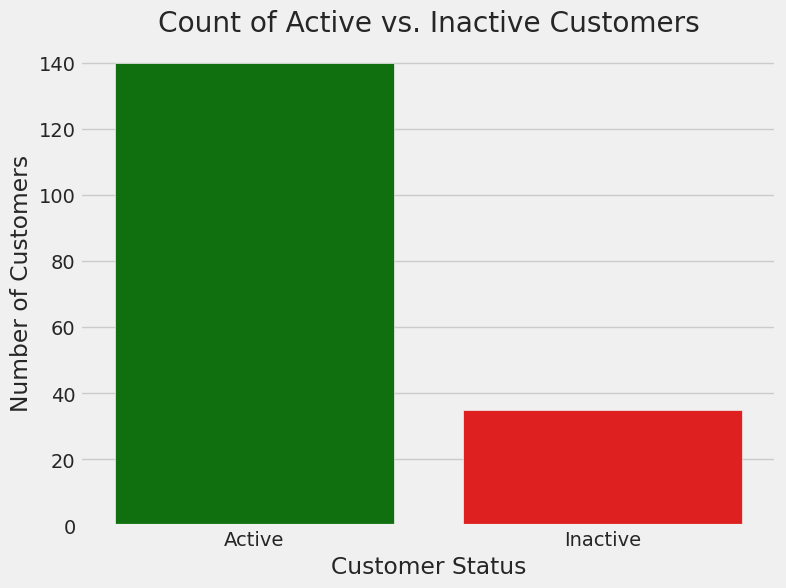

In [20]:
plt.figure(figsize=(8, 6))
sns.barplot(x=status_counts.index, y=status_counts.values, hue=status_counts.index, palette=status_colors, legend=False)
plt.title('Count of Active vs. Inactive Customers')
plt.ylabel('Number of Customers')
plt.xlabel('Customer Status')
plt.show()

### 4.3 Analyze Characteristics of Inactive Customers

What do our inactive customers have in common? By merging our status segments back with the main dataset, we can analyze the regional and channel distribution of these customers.

**Key Finding:** The **Midwest** region has the highest absolute number of inactive customers, which is concerning as it's also our highest revenue region. The **Wholesale** channel accounts for the majority of lost customers.

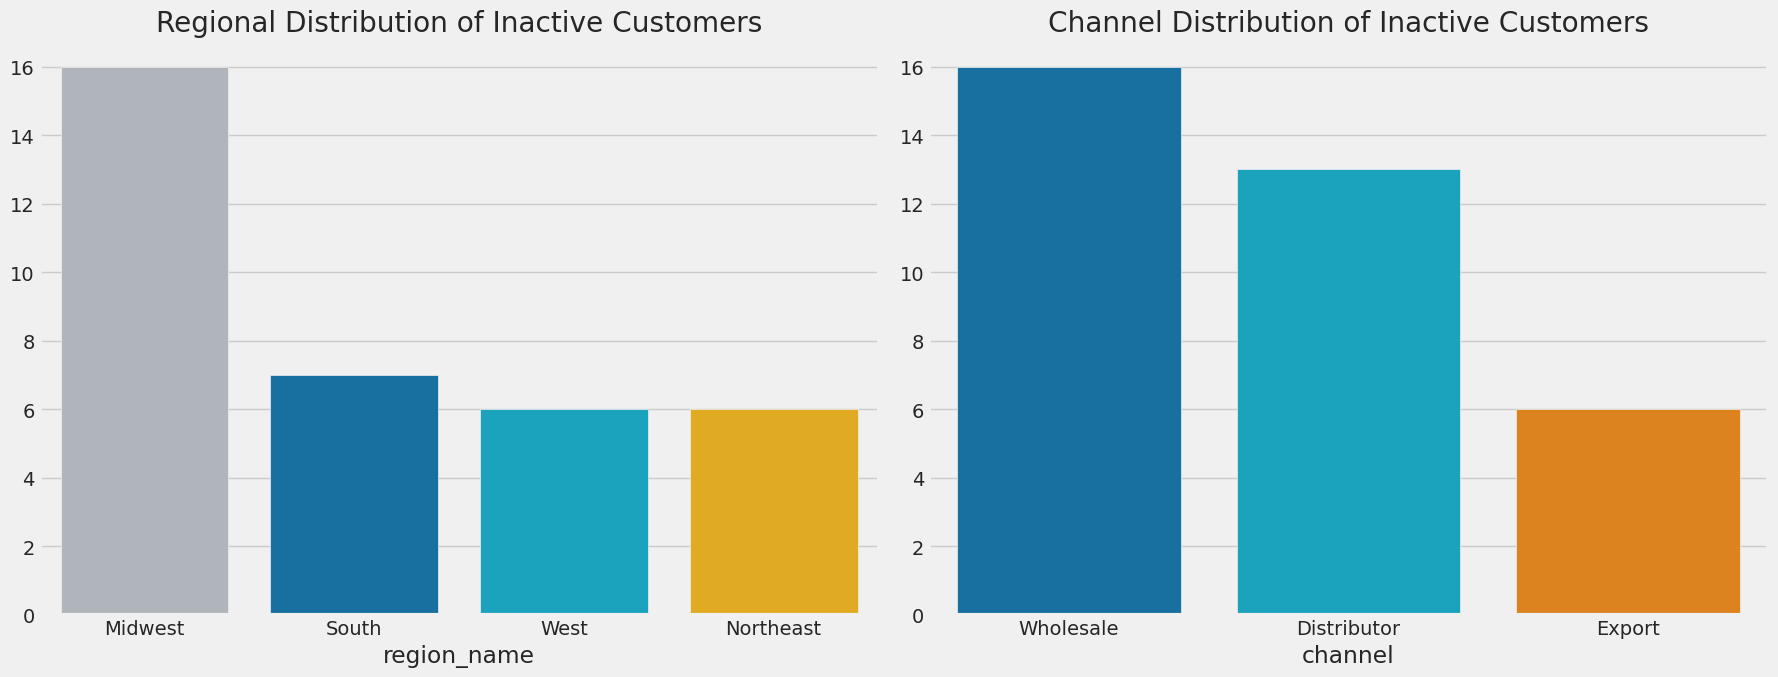

In [21]:
inactive_customers = customer_activity[customer_activity['status'] == 'Inactive']['customer_names']
inactive_df = merged_df[merged_df['customer_names'].isin(inactive_customers)]
inactive_region_dist = inactive_df.drop_duplicates(subset='customer_names')['region_name'].value_counts()
inactive_channel_dist = inactive_df.drop_duplicates(subset='customer_names')['channel'].value_counts()

fig, ax = plt.subplots(1, 2, figsize=(18, 7))
sns.barplot(x=inactive_region_dist.index, y=inactive_region_dist.values, hue=inactive_region_dist.index, ax=ax[0], palette=region_colors, legend=False)
ax[0].set_title('Regional Distribution of Inactive Customers')
sns.barplot(x=inactive_channel_dist.index, y=inactive_channel_dist.values, hue=inactive_channel_dist.index, ax=ax[1], palette=channel_colors, legend=False)
ax[1].set_title('Channel Distribution of Inactive Customers')
plt.tight_layout()
plt.show()